# Plotting fishing catches simulated by DBPM
**Author**: Denisse Fierro Arcos  
**Date**: 2025-02-06  

## Loading relevant libraries

In [1]:
import os
os.chdir('/g/data/vf71/la6889/dbpm_southern_ocean/scripts/')
from glob import glob
import xarray as xr
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1, memory_limit = 0)

## Defining basic variables to run gridded DBPM

In [2]:
#Name of region and model resolution
region = 'fao-88'
reg_name = 'west_antarctica'
model_res = '025deg'
runs = '_simask'

# Paths to input and output folders
base_folder = f'/g/data/vf71/la6889/dbpm_inputs/{reg_name}'
gridded_inputs = os.path.join(base_folder, 'gridded_params', model_res)
gridded_outputs_old_eff = os.path.join(base_folder, 'run_fishing', model_res)
gridded_outputs_new_eff = os.path.join(
    base_folder, 'run_fishing_new_eff', model_res)
gridded_outputs_seaice = os.path.join(
    base_folder, 'gridded_dbpm_outputs_seaicemask', model_res)
outputs_folder = os.path.join(base_folder, 'gridded_dbpm_outputs', model_res)

## Loading area file to create mask for region

In [9]:
mask = xr.open_zarr(glob(os.path.join(
    base_folder, 'gridded', model_res, '*areacello*'))[0])['cellareao']
mask = xr.where(np.isfinite(mask), 1, np.nan)

In [10]:
# Getting longitude for filtering
if mask.lon.max() > 180:
    lon_filter = ((mask.lon+180)%360)-180
else:
    lon_filter = mask.lon

## Loading sea ice data
Calculate mean sea ice cover per year and identify the edge of the sea ice, which is defined as the grid cells where sea ice concentration is 15\%.

In [54]:
si = xr.open_zarr(glob(os.path.join(base_folder, 'gridded', model_res, 
                                    '*obsclim_siconc_*month*'))[0])['siconc']
#Calculate montly sea ice mean
si_month = si.groupby('time.month').mean('time')*mask
#Convert to sea ice extent
sie_month = xr.where(si_month >= 15, 1, 0)*mask

## Loading total catches estimated by DBPM

In [48]:
# Load estimated catches
total_catch = xr.open_zarr(glob(
    os.path.join(outputs_folder, f'total_catches{runs}_{model_res}_*'))[0])['total_catches']

# Calculate mean catches per year - Model period only (1961-2010)
total_catch_sub = total_catch.sel(time = slice('1961', None))

## Monthly means for catches

In [57]:
catch_month = total_catch.groupby('time.month').mean('time', skipna = True)*mask

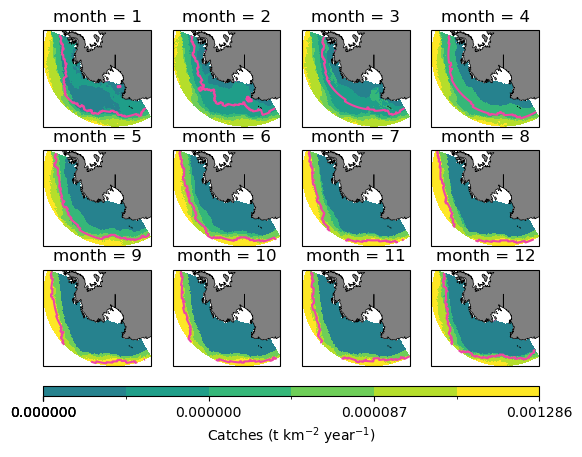

In [58]:
fig = plt.figure()#figsize = (12, 6))
levels = catch_month.quantile(np.arange(0, 1.1, 0.1)).values
gs = gridspec.GridSpec(nrows = 4, ncols = 4, height_ratios = (1, 1, 1, 0.1))
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

ax = {}
for i in range(12):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    p = catch_month.isel(month = i).plot(levels = levels, ax = ax[i], #cmap = cm.cm.speed,
                       add_colorbar = False, transform = ccrs.PlateCarree())
    sie_month.isel(month = i).plot.contour(levels = [0], ax = ax[i],
                                              colors = '#ef47a2',
                                              add_colorbar = False, 
                                          transform = ccrs.PlateCarree())
    ax[i].add_feature(land_50m)

cbar = fig.colorbar(p, cax = plt.subplot(gs[-1,:]), 
                    orientation = 'horizontal')
cbar.set_label('Catches (t km$^{-2}$ year$^{-1}$)', y = .95)
fout = os.path.join('../outputs', f'mean_month_catch_{region}_{model_res}.png')
# plt.savefig(fout, dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Calculate mean over entire model period 

In [25]:
total_catch_sub = total_catch_sub.mean('time')*mask

In [63]:
#Calculate sea ice mean
si_mean = si.mean('time')*mask
#Convert to sea ice extent
sie_mean = xr.where(si_mean >= 15, 1, 0)*mask

## Merging means for all regions 

Initialising empty dictionary to store catches and sea ice information for all regions.

In [10]:
catch_all = {}
sie_all = {}

Adding data for each region into dictionary.

In [27]:
catch_all[region] = total_catch_sub

In [ ]:
sie_all[region] = sie_mean

Saving results for future reference

In [32]:
# Transforming to dataset
catch_all = xr.Dataset(catch_all)
catch_all = catch_all.chunk({'lat': -1, 'lon': -1})

# Saving results
catch_all.to_zarr(
    os.path.join('../data', f'mean_catch_all_regions{runs}_{model_res}_1961-2010.zarr'),
consolidated = True, mode = 'w')

In [28]:
# Transforming to dataset
sie_all = xr.Dataset(sie_all)
sie_all = sie_all.chunk({'lat': -1, 'lon': -1})

# Saving results
sie_all.to_zarr(
    os.path.join('../data', 
                 f'mean_sea-ice-edge_all_regions_{model_res}_1961-2010.zarr'),
consolidated = True, mode = 'w')

### **Optional:** Loading mean catches

In [85]:
catch_all = xr.open_zarr(
    os.path.join('../data', 
                 f'mean_catch_all_regions{runs}_{model_res}_1961-2010.zarr'))
sie_all = xr.open_zarr(
    os.path.join('../data', 
                 f'mean_sea-ice-edge_all_regions_{model_res}_1961-2010.zarr'))

## Plotting mean catches

In [86]:
#Loading bathymetry files to include in maps
bathy_files = glob(f'/g/data/vf71/la6889/dbpm_inputs/*/gridded/{model_res}/*obsclim_deptho_*/')
bathy = {}

for f in bathy_files:
    [reg_code] = re.findall('fao-[0-9]{2}', f)
    bathy[reg_code] = xr.open_zarr(f)['deptho']

bathy = xr.Dataset(bathy)
bathy = bathy.chunk({'lat': -1, 'lon': -1})

In [75]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)

## Composite maps - all regions, mutiple decades

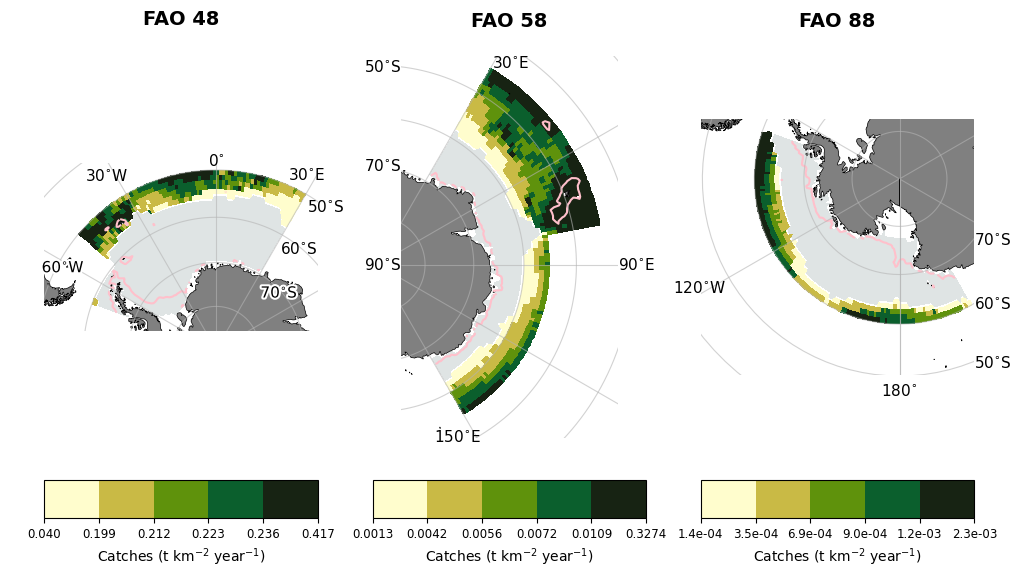

In [87]:
fig = plt.figure(figsize = (12, 6))

fao_reg = sorted(list(catch_all.keys()))

gs = gridspec.GridSpec(nrows = 2, ncols = 3, height_ratios = (1, 0.1))

ax = {}
plots = {}
for i, r in enumerate(fao_reg):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    da = catch_all[r].where(catch_all[r] > 0)
    da_nocatch = catch_all[r].where(catch_all[r] == 0)
    levels = da.quantile(np.arange(0, 1.1, 0.2)).values
    plots[r] = da.plot(levels = levels, ax = ax[i], cmap = cm.cm.speed,
                       add_colorbar = False, transform = ccrs.PlateCarree())
    da_nocatch.plot.contourf(ax = ax[i], colors = ["#dfe4e4", "#3498db"], levels = [0, 1], 
                             add_colorbar = False, transform = ccrs.PlateCarree())
    bathy[r].plot.contour(ax = ax[i], levels = [1000], colors = 'pink', add_colorbar = False,
                          transform = ccrs.PlateCarree())
    ax[i].add_feature(land_50m)
    #Customise area shown in the maps
    coord_lab = 11
    if r == 'fao-48':
        ax[i].text(0.5, 1.85, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([-65, 32.5, -80, -48], crs = ccrs.PlateCarree())
        plt.text(0.15, 0.89, '$30^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.01, 0.35, '$60^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab, 
                 path_effects = [PathEffects.withStroke(linewidth = 3, foreground = 'w')])
        plt.text(0.60, 0.98, '$0^{\circ}$', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.89, 0.9, '$30^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.79, 0.2, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab,
                 path_effects = [PathEffects.withStroke(linewidth = 3, foreground = 'w')])
        plt.text(0.86, 0.46, '$60^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.96, 0.71, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    elif r == 'fao-58':
        ax[i].text(0.5, 1.09, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([30, 136, -80, -42.5], crs = ccrs.PlateCarree())
        plt.text(-0.17, 0.96, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.17, 0.7, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.17, 0.44, '$90^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.42, 0.97, '$30^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.44, '$90^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.15, -0.01, '$150^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    else:
        ax[i].text(0.5, 1.38, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([158, 287.5, -80, -49.5], crs = ccrs.PlateCarree())
        plt.text(1, 0.51, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.26, '$60^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.03, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.1, 0.32, '$120^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.66, -0.08, '$180^{\circ}$', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    
    ax[i].set_title('')
        
    #Remove border around map
    [s.set_visible(False) for s in ax[i].spines.values()]
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                         color = "#b4b4b4", alpha = 0.6)
    # #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}

cbar = fig.colorbar(plots['fao-48'], cax = plt.subplot(gs[3]), 
                    orientation = 'horizontal', pad = 0.075, format = '%.3f')
cbar.set_label('Catches (t km$^{-2}$ year$^{-1}$)', y = .95)
cbar.ax.tick_params(labelsize = 8.5)
cbar = fig.colorbar(plots['fao-58'], cax = plt.subplot(gs[4]), 
                    orientation = 'horizontal', pad = 0.075)
cbar.ax.tick_params(labelsize = 8.5)
cbar.set_label('Catches (t km$^{-2}$ year$^{-1}$)', y = .95)
cbar = fig.colorbar(plots['fao-88'], cax = plt.subplot(gs[5]), 
                    orientation = 'horizontal', pad = 0.075, format = '%4.1e')
cbar.set_label('Catches (t km$^{-2}$ year$^{-1}$)', y = .95)
cbar.ax.tick_params(labelsize = 8.5)

fout = os.path.join('../outputs', f'mean_catch_all_regions{runs}_{model_res}.png')
plt.savefig(fout, dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)